In [2]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt

from scipy import special
from tqdm import tqdm
from ipywidgets import interact
from scipy import stats
from matplotlib.colors import LogNorm

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

## Exercise on Radio Interferometry
Now try yourself to create an interferometry telescope simulation in 2D. The situation that we will simulate is very similar to case illustrated below

<img src="images/coords_baseline.png" alt="Drawing" style="width: 500px;"/>


Here, we assume the _flat sky approximation_, _i.e._: all object are at the same distance on the sky. 

The telescope point to a direction in the sky $\vec{s}_0$, also refered as the phase centre. Therefore, the position of each source in the sky, $\vec{s}$, is defined in this reference of the phase centre by the projected vector $\sigma$. The position of this vector is often expressed in the so called $lmn$-coordinates. 

Similarly, for each pair of antennas we want to define the projection of their baseline, $\vec{b}$, on the sky map based on the observed wavelength.  


### Guidelines for creating your own Interferometric simulation:

1) Use the gaussian point source defined here below as sky model.
    - assume the source is centered at the phase direction
    - define some arbitrary $lmn$-coordinate accordingly
2) Decide a layout for your inteferometric telescope array
    - asseme $XYZ$-coordinate of each antenna to be in the reference frame of the telescope array centre
3) Calculate the $uvw$-coordinates for each pair of antennas
    - for each antenna $i$ and $j$ calculate the baseline vector: $\vec{b}_{ij} = \frac{\vec{r}_i - \vec{r}_j}{\lambda}$
    - you should obtain $N_B = \frac{N_{ant} (N_{ant}-1)}{2}$ many baselines
4) Calculate the Visibility, $V_{ij}$, for each baseline 
    - remember the definition for the discrete case is: 
    $$V_{ij} = \frac{1}{\Omega}\sum_k I_{sky}(\vec{s}_k)\,e^{-2\pi\, i\, \vec{b}_{ij}\cdot\vec{s}_k}$$
    
    - Here, the index $k$ is indicating each pointing $\vec{s}_k$ in the sky model and $\Omega$ is the solid angle (i.e. FoV).
    - Sometime, it is helpfull to look at the Visibility matrix, $\mathcal{V}$, to look at the correlation between different pair of antennas.
5) Get the reconstructed image
    - Grid the visibility point into the $uv$-plane, also you can count the number of visibility points per bin to account for the $uv$-sampling (more advanced topic)
    - Perform a 2D inverse Fast Fourier Transform (apply fftshift in numpy) and compare the reconstracted image, $I^{reconstr}_{sky}$, with the sky model, $I_{sky}$.

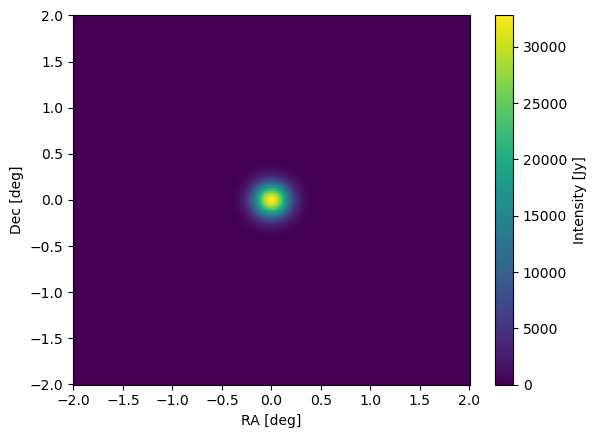

In [17]:
# define a 2D gaussian function
def gaussian_2d(x, y, mean, cov):
    """ a simple 2D gaussian distribution """
    x_diff = x - mean[0]
    y_diff = y - mean[1]
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * (x_diff**2 * inv_cov[0, 0] + y_diff**2 * inv_cov[1, 1] + 2 * x_diff * y_diff * inv_cov[0, 1])
    prefactor = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    return prefactor * np.exp(exponent)

# define some mock distance in the lmn-coordinates
SKY_SIZE = 512
dist = np.linspace(-2.*u.deg, 2.*u.deg, SKY_SIZE).to('rad').value

# Create a grid of points (we ignore third dimension, i.e. n-axis)
l_coord, m_coord = np.meshgrid(dist, dist)
lmn_coord = np.dstack((l_coord, m_coord)).reshape(-1, 2)

# Define parameters for the 2D Gaussian source
mu = np.array([0, 0])  # Mean
sigma = np.array([[(1*u.arcsec).to('rad').value, 0], [0, (1*u.arcsec).to('rad').value]])  # Covariance matrix

# Get the sky model
I_sky = gaussian_2d(x=l_coord, y=m_coord, mean=mu, cov=sigma)

# Plot the 2D Gaussian distribution
plt.pcolormesh(np.rad2deg(l_coord*u.rad).value, np.rad2deg(m_coord*u.rad).value, I_sky, cmap='viridis')
plt.ylabel('Dec [deg]'), plt.xlabel('RA [deg]')
plt.colorbar(label='Intensity [Jy]')
plt.show()

## Solution

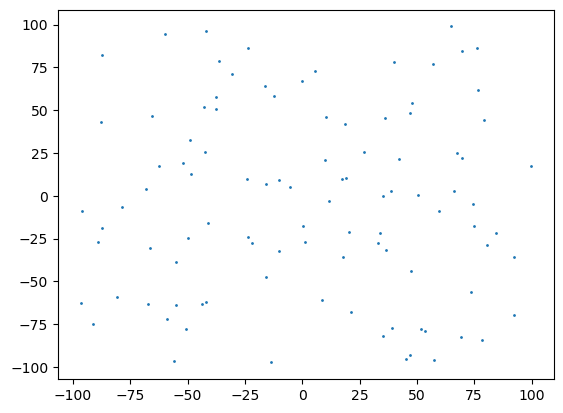

In [18]:
SIZE = 100

# get random XY-coordinated (with reference to the layout centre) in meter units
np.random.seed(2024)
x = np.random.uniform(-100., 100., size=SIZE) * u.m
np.random.seed(2023)
y = np.random.uniform(-100., 100., size=SIZE) * u.m

# get antennas on a line (kind of like VLA) 
#x = np.linspace(-100, 100, SIZE)
#y = np.linspace(-100, 100, SIZE)

# define random XYZ-coordinates of the antennas layout
xyz_coord = np.stack((x, y)).T

# Hirax-like layout
#SIZE = 5
#x = np.linspace(-100., 100., SIZE) * u.m
#X, Y = np.meshgrid(x, x)
#xyz_coord = np.dstack((X, Y)).reshape(-1, 2)

# quick plot
plt.scatter(xyz_coord[:,0], xyz_coord[:,1], s=1)

Get the number of antennas, calculate the number of baselines for the given configuration adn define other observational variables

In [19]:
# get number of antennas
N_ant = xyz_coord.shape[0]

# calculate number of baselines
N_B = int(N_ant*(N_ant-1)/2)

print(N_ant, N_B)

# define observed frequency and corresponding wavelenght
freq = 100*u.MHz
lam = (cst.c/freq).to('m')

print(lam, freq)

# get pairs list
pair_comb = list(itertools.combinations(range(N_ant), 2))
assert np.shape(pair_comb)[0] == N_B

100 4950
2.99792458 m 100.0 MHz


You can try to run the cell below. This will give you an idea how big your visibilities will be. As you soon realize if you choosed a too large __SIZE__ for the sky image you will quickly run out of memory.
<pre>
# calculate the dot product between all the baselines and all the sky coordinates
dot_prod = np.dot(baselines_coord, lmn_coord.T)

print(dot_prod.shape)
</pre>

Loop through the baselines and calculate the distance and devide to the wavelenght to get the baseline coordinates, then calculate the visibilities for each pair of antennas (i.e. each baselines)

In [20]:
# Define baseline coordinates array
baselines_coord = np.empty((N_B, xyz_coord.shape[1]))

# Define visibilities array
V = np.empty(N_B, dtype=np.complex128)

# Define visibilities matrix
V_matrix = np.zeros((N_ant, N_ant))

# loop trought different baseline
for i_b in tqdm(range(N_B)):
    ii, jj = pair_comb[i_b]

    # calculate the distance between antennas in unit of wavelength
    bl = (xyz_coord[ii]-xyz_coord[jj])

    # store baseline (in uv-coordinates)
    baselines_coord[i_b] = bl

    # calculate fringe patter
    fringe_pattern = np.exp(-2j * np.pi * np.dot(bl, lmn_coord.T) / lam)

    # discrete integration
    V[i_b] = np.sum(I_sky[...,None].reshape(-1) * fringe_pattern)

    # store visibility matrix
    V_matrix[ii, jj] = np.abs(V[i_b])

# pairs are only for one corner
V_matrix = V_matrix + np.conj(V_matrix.T)

# define the length of the largest baseline
max_baseline_length = np.linalg.norm(baselines_coord, axis=1).max() * u.m

# print the baseline and sky lmn-coordinates shape
print(baselines_coord.shape, lmn_coord.shape)

100%|██████████████████████████████████████| 4950/4950 [00:42<00:00, 117.59it/s]

(4950, 2) (262144, 2)


### Remarks:
in this example, we do not take into consideration the mirrored $uv$ points (memory limitation). 

One would have $2\times$ the number of baselines and visibility point as $V(u, v) = V^*(-u, -v)$. Therefore, we can stack togheter and mirror the $uv$-points

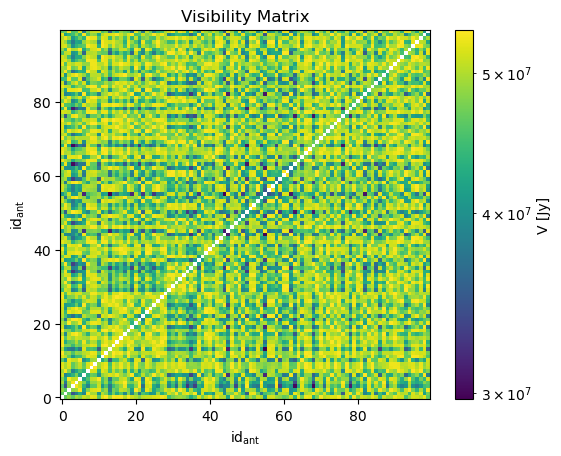

In [21]:
plt.title('Visibility Matrix')
plt.imshow(V_matrix, origin='lower', cmap='viridis', norm=LogNorm())
plt.xlabel(r'id$_\mathrm{ant}$'), plt.ylabel(r'id$_\mathrm{ant}$')
plt.colorbar(label='V [Jy]')

Define the Field of View (in radiant) and the angular resolution of the image.

In [22]:
FoV = lmn_coord.max() - lmn_coord.min()
angl_res = lam / max_baseline_length

Binning the Visibility point $V(u,v)$ into a grid in the $uv$-space will give the so called uv-plance, $V(\Delta u,\Delta v)$. At the same time, gridding 

In [23]:
UMAX = 800
URES = 1. / FoV
USIZE = int(UMAX / URES)

u_bin = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)

# binn the visibility points
uv_plane = stats.binned_statistic_2d(x=baselines_coord[:,0], y=baselines_coord[:,1], 
                                     values=V.real, statistic='sum', bins=[u_bin, u_bin]).statistic

uv_sampl = stats.binned_statistic_2d(x=baselines_coord[:,0], y=baselines_coord[:,1], 
                                     values=None, statistic='count', bins=[u_bin, u_bin]).statistic

uv_plane /= np.where(uv_sampl > 0, uv_sampl, 1)

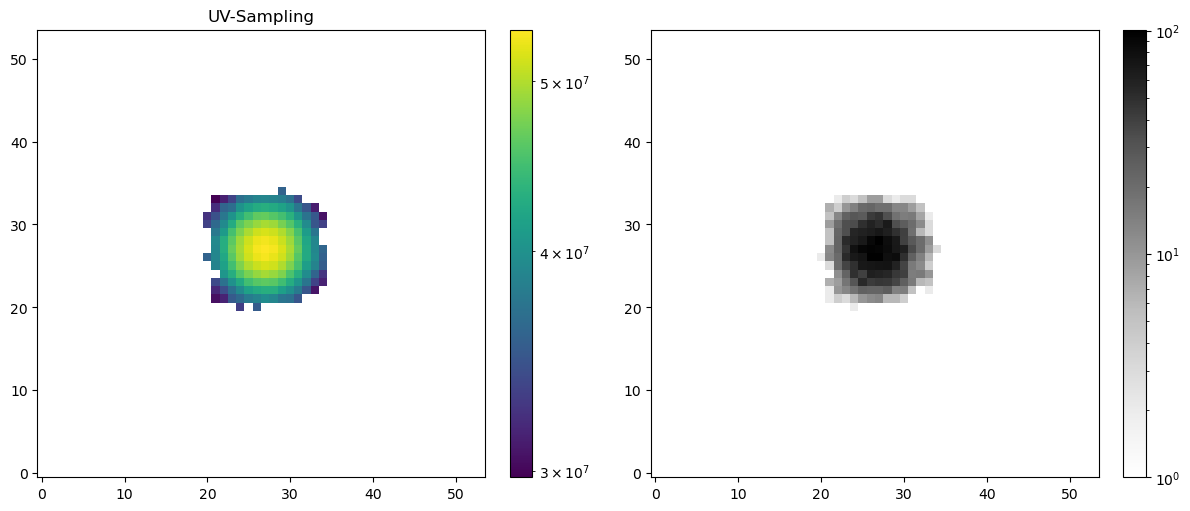

In [24]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)

# plot reconstructed image
axs[0].set_title('UV-Coverage')
im = axs[0].imshow(uv_plane, norm=LogNorm(), cmap='viridis', origin='lower')
plt.colorbar(im, ax=axs[0])

axs[0].set_title('UV-Sampling')
im = axs[1].imshow(uv_sampl, norm=LogNorm(), cmap='Greys', origin='lower')
plt.colorbar(im, ax=axs[1])

Calculate the 2D inverse Fast-Fourier Transform to get the reconstructed image

In [25]:
I_sky_reconstruct = np.fft.ifft2(uv_plane)
I_sky_reconstruct = np.fft.fftshift(np.abs(I_sky_reconstruct))

print('Size of the reconstructed image', USIZE)

Size of the reconstructed image 55


Plot the results

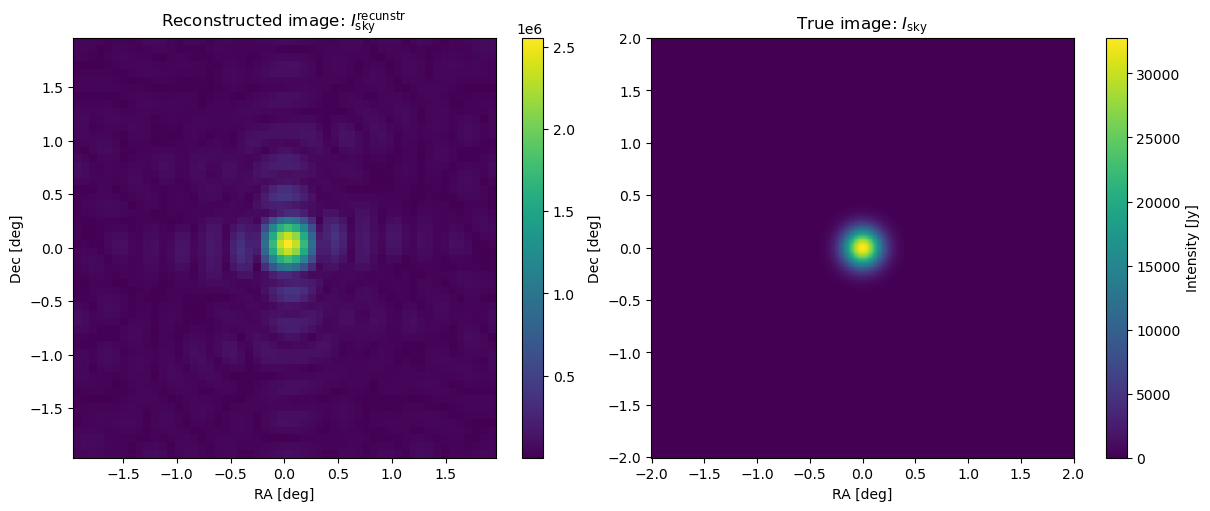

In [28]:
# from the Fourier-frequency get the spatial dimension
x = np.fft.fftshift(np.fft.fftfreq(USIZE, URES))

fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)

# plot reconstructed image
axs[0].set_title('Reconstructed image: $I^\mathrm{recunstr}_\mathrm{sky}$')
im = axs[0].pcolormesh((x*u.rad).to('deg').value, (x*u.rad).to('deg').value, I_sky_reconstruct)
plt.colorbar(im, ax=axs[0])

axs[1].set_title('True image: $I_\mathrm{sky}$')
im = axs[1].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, I_sky)
plt.colorbar(im, ax=axs[1], label='Intensity [Jy]')

for ax in axs:
    ax.set_ylabel('Dec [deg]'), ax.set_xlabel('RA [deg]')


## More exercise

Place the field center at $(\alpha_0,\delta_0) = $ (5h 30m,60$^{\circ}$). With a sky signal composed of three sources, with positions given in RA ($\alpha$) and DEC ($\delta$):
* Source 1: (5h 32m 0.4s,60$^{\circ}$-17' 57'') - 1 Jy
* Source 2: (5h 36m 12.8s,-61$^{\circ}$ 12' 6.9'') - 0.5 Jy
* Source 3: (5h 40m 45.5s,-61$^{\circ}$ 56' 34'') - 0.2 Jy

Look also at the $uv$-coverage tutorials.
